In [2]:
%matplotlib inline
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
#from imports import *

# Load image lag

In [3]:
all_lags = pd.read_csv('../../data/for_analysis/image_lags.csv', dtype=object)
all_lags.shape

(140496, 10)

In [4]:
all_lags.head(2)

,image,release,type,last_updated,cve_lag,bug_lag,vlag,tlag,outdated,packages
0,010309:mmmiddleware:0.9.25,Stable,community,2017-11-01,0.0,0.0,0.0,0.0,0.0,82
1,010309:mmmiddleware:0.9.26,Stable,community,2017-11-12,0.0,0.0,0.0,0.0,0.0,82


In [5]:
all_lags.rename(columns={'outdated':'pkg',
                         'vlag':'vers',
                         'tlag':'time',
                         'cve_lag':'vuln',
                         'bug_lag':'bug'
                        }, inplace=True)

In [6]:
for x in ['vuln','bug','time','vers','pkg','packages']:
    all_lags[x] = all_lags[x].apply(float)

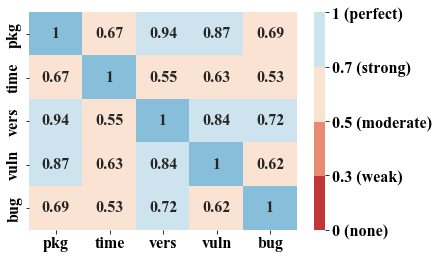

In [7]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

bounds = [0, 0.3, 0.5, 0.7, 1]
labels = ['none', 'weak', 'moderate', 'strong', 'perfect']
base = sns.color_palette('RdBu', n_colors=len(bounds) + 1)

cmap = LinearSegmentedColormap.from_list('segmented', list(zip(bounds, base)), len(bounds))
norm = BoundaryNorm(bounds, ncolors=len(bounds) - 1)

corr = (all_lags
    [['pkg', 'time', 'vers', 'vuln', 'bug']]
    .corr(method="pearson")
    [['pkg', 'time', 'vers', 'vuln', 'bug']]
)

ax = sns.heatmap(
    corr, 
    annot = True, 
    cmap=cmap, 
    cbar_kws={'ticks': bounds}, 
    norm=norm, 
    vmin=0, 
    vmax=1
)
ax.collections[-1].colorbar.set_ticklabels(['{} ({})'.format(a, b) for a,b in zip(bounds, labels)])
for label in ax.get_yticklabels():
    label.set_verticalalignment('center')

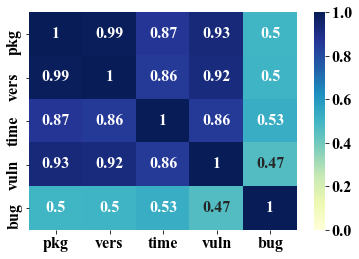

In [8]:
corr = (all_lags
 [['pkg','vers','time','vuln','bug']]
 .corr(method="spearman"))
ax=sns.heatmap(corr, annot = True, cmap="YlGnBu", vmin=0, vmax=1)

In [9]:
print('correlation with the number of packages')
for i, col1 in enumerate(['vuln','bug','time','vers','pkg']):
    print(col1, scipy.stats.pearsonr(all_lags[col1], all_lags['packages']))

correlation with the number of packages
vuln (0.18256705396190703, 0.0)
bug (0.01704202027291113, 1.678137952857731e-10)
time (0.165418945464823, 0.0)
vers (0.1543593141295828, 0.0)
pkg (0.21266599206798795, 0.0)


Text(0.5, 1, 'official - community')

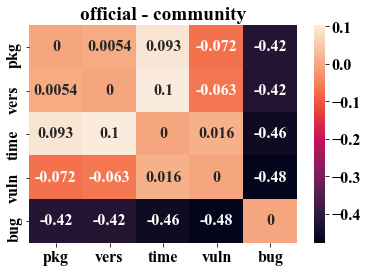

In [10]:
corr = (all_lags
        .query('type=="official"')
        [['pkg','vers','time','vuln','bug']]
        .corr(method="spearman"))

corr2 = (all_lags
        .query('type=="community"')
        [['pkg','vers','time','vuln','bug']]
        .corr(method="spearman"))

ax=sns.heatmap(corr - corr2, annot = True)
ax.set_title('official - community')

# PCA

In [11]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

#features = ['pkg', 'time', 'vers', 'vuln', 'bug']
features = ['vers', 'time', 'vuln', 'bug']

# Separating out the features
x = all_lags.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

#x = QuantileTransformer(output_distribution='normal').fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=len(features))
principalComponents = pca.fit_transform(x)

In [12]:
pca.explained_variance_ratio_

array([0.73743549, 0.12933707, 0.09914583, 0.03408161])

In [13]:
pca.components_

array([[ 0.5313995 ,  0.45150387,  0.52752884,  0.48525472],
       [ 0.35164782, -0.86083325,  0.04694566,  0.364837  ],
       [ 0.29133964, -0.17303693,  0.55407202, -0.76038387],
       [ 0.71349814,  0.15864613, -0.64227224, -0.23073401]])

In [14]:
for y in pca.components_:
    print(y/y.sum())

[0.26627398 0.22623983 0.26433446 0.24315172]
[-3.61024492  8.83787323 -0.48197469 -3.74565362]
[-3.31033369  1.96612442 -6.29561862  8.63982789]
[-827.73618228 -184.04692858  745.10631973  267.67679114]


In [15]:
df = pd.DataFrame(
    index=['component 1', 'component 2', 'component 3', 'component 4',],
    columns=features,
    data=pca.components_
)
df['explained variance'] = pca.explained_variance_ratio_

In [20]:
df

,vers,time,vuln,bug,explained variance
component 1,0.531400,0.451504,0.527529,0.485255,0.737435
component 2,0.351648,-0.860833,0.046946,0.364837,0.129337
component 3,0.291340,-0.173037,0.554072,-0.760384,0.099146
component 4,0.713498,0.158646,-0.642272,-0.230734,0.034082


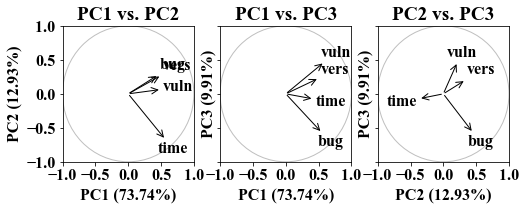

In [17]:
import matplotlib
fig, axes = matplotlib.pyplot.subplots(ncols=3, sharex=True, sharey=True)
fig.set_size_inches(8, 2.5)


for i, (a, b) in enumerate([(1,2), (1,3), (2,3)]):
    ax = axes[i]
    
    c1 = 'component {}'.format(a)
    c2 = 'component {}'.format(b)
    ax.add_artist(matplotlib.patches.Circle((0, 0), 1, alpha=0.25, facecolor='w', edgecolor='k'))
    #ax.axhline(y=0, color='k', alpha=0.25)
    #ax.axvline(x=0, color='k', alpha=0.25)
    
    ax.set(
        title='PC{} vs. PC{}'.format(a, b),
        xlabel='PC{} ({:.2%})'.format(a, df['explained variance'].loc[c1]),
        xlim=(-1, 1),
        ylabel='PC{} ({:.2%})'.format(b, df['explained variance'].loc[c2]),
        ylim=(-1, 1),
    )
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
    
    for v in features:
        x, y = df[v].loc[c1], df[v].loc[c2]
        ax.annotate(v, (0, 0), xytext=(x, y), arrowprops={'arrowstyle': '<-'})
        


In [23]:
print(df.to_latex(
    columns=['time', 'vers', 'vuln', 'bug', 'explained variance'],
    float_format='{:0.2f}'.format,
    bold_rows=True,
))

\begin{tabular}{lrrrrr}
\toprule
{} &  time &  vers &  vuln &   bug &  explained variance \\
\midrule
\textbf{component 1} &  0.45 &  0.53 &  0.53 &  0.49 &                0.74 \\
\textbf{component 2} & -0.86 &  0.35 &  0.05 &  0.36 &                0.13 \\
\textbf{component 3} & -0.17 &  0.29 &  0.55 & -0.76 &                0.10 \\
\textbf{component 4} &  0.16 &  0.71 & -0.64 & -0.23 &                0.03 \\
\bottomrule
\end{tabular}



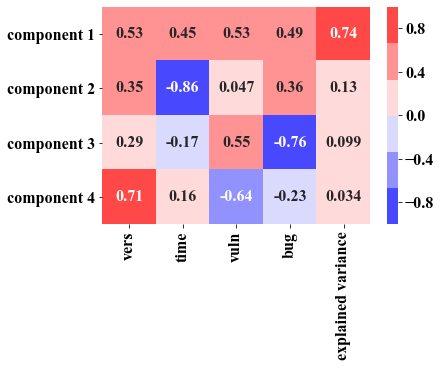

In [24]:
ax = sns.heatmap(
    df, 
    annot = True, 
    cmap=sns.color_palette('bwr'), 
    vmin=-1, 
    vmax=1
)

## Linear regressions

In [ ]:
from sklearn.linear_model import LinearRegression
scores = dict()
coef = dict()

Z = all_lags[features]
Z = (Z - Z.mean()) / Z.std()

for feature in features:
    remaining = [x for x in features if x != feature]
    X, y = Z[remaining], Z[feature]
    reg = LinearRegression()
    reg.fit(X, y)
    scores[feature] = reg.score(X, y)
    coef[feature] = list(zip(remaining, reg.coef_))